In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from albumentations import *
from skimage.transform import resize

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model

import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
SHAPE = (224, 224, 3)
BATCH_SIZE = 24
EPOCHS = 100
N_SPLITS = 5
SEED = 1881
TRAIN_TEST_RATIO = 0.2

BASE_DIR     = "../../data/BreaKHis_v1/histology_slides/breast/"
DATASET_MODE = "40X"

In [3]:
class BREAKHIST_DATASET:
    
    """
    input_shape           --> TUPLE.wanted image size
    batch_size            --> INT.yielding data size for every iteration
    orders                --> LIST.which images will be used. max=len(all_images). it can be used for K-fold(CV).
    base_dir              --> STR.the DIR which is include "benign" and "malignant" dirs.
    dataset_mode          --> STR. Which type of images will be used: "40X", "100X", "200X", "400X".
    seed                  --> INT. This allow to dataset generator to more reproduciable and it ensures that x and y are shuffled with compatible.
    augment               --> BOOL. Augment data or not.
    train_test_ratio      --> How much of data will be used as test set.
    ---------
    GENERAL_CLASSES       --> LIST.["benign", "malignant"]
    BENIGN_SUB_CLASSES    --> LIST.["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
    MALIGNANT_SUB_CLASSES --> LIST.["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
    """
    
    def __init__(self, input_shape, batch_size, orders, base_dir, dataset_mode, seed, train_test_ratio, augment=True):
        self.SHAPE                 = input_shape
        self.BATCH_SIZE            = batch_size
        self.arr                   = orders
        self.DATASET_MODE          = dataset_mode
        self.SEED                  = seed
        self.TT_RATIO              = train_test_ratio
        self.AUG                   = augment
        
        self.BASE_DIR              = base_dir
        self.GENERAL_CLASSES       = ["benign", "malignant"]
        self.BENIGN_SUB_CLASSES    = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
        self.MALIGNANT_SUB_CLASSES = ["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
        
        
    def get_paths_n_labels(self):

        x      = []
        label = []

        for ix1, a in enumerate(self.GENERAL_CLASSES):
            if ix1 == 0:
                for ix2, b in enumerate(self.BENIGN_SUB_CLASSES):
                    path1 = self.BASE_DIR+a+"/SOB/"+b
                    for c in os.listdir(path1):
                        path2 = path1+"/"+c+"/"+self.DATASET_MODE
                        for img_name in os.listdir(path2):
                            path3 = path2+"/"+img_name

                            # x
                            img_path = path3 #np.array(Image.open(path3), dtype=np.float16)

                            # y
                            main_targets = np.zeros((2), dtype=np.float32) # BENIGN OR MALIGNANT
                            main_targets[ix1] = 1.

                            # Store the values
                            x.append(img_path)
                            label.append(main_targets)

                            
            if ix1 == 1:
                for ix2, b in enumerate(self.MALIGNANT_SUB_CLASSES):
                    path1 = self.BASE_DIR+a+"/SOB/"+b
                    for c in os.listdir(path1):
                        path2 = path1+"/"+c+"/"+self.DATASET_MODE
                        for img_name in os.listdir(path2):
                            path3 = path2+"/"+img_name

                            # x
                            img_path = path3  #np.array(Image.open(path3), dtype=np.float16)

                            # y
                            main_targets = np.zeros((2), dtype=np.float32) # BENIGN OR MALIGNANT
                            main_targets[ix1] = 1.
                     
                            # Store the values
                            x.append(img_path)
                            label.append(main_targets)
                           
        return x, label
    
    def __len__(self):
        return len(self.get_paths_n_labels()[0])
    
    def get_img(self, img_path):
        img = Image.open(img_path)
        return np.array(img)
    
    def augmenting(self, img):
        if self.AUG:
            augment = Compose([VerticalFlip(p=0.5),
                               HorizontalFlip(p=0.5),
                               RandomBrightnessContrast(p=0.3),
                               ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0.2, rotate_limit=20)])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    
    def resize_and_normalize(self, img):
        img = resize(img, self.SHAPE)
        return img
    
    def get_shuffled_data(self):
        img_paths, labels = self.get_paths_n_labels()

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
        
    def split_train_test(self, get):  # get=={"train","test"}
        img_paths, labels = self.get_shuffled_data()
        x_train, x_test, y_train, y_test = train_test_split(img_paths, labels, test_size=self.TT_RATIO, random_state=self.SEED)
        
        if get=='train':
            return x_train, y_train
        
        elif get=='test':
            return x_test, y_test
    
    def data_generator(self):
        img_paths, labels = self.split_train_test(get="train")
        
        while True:
            x = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y = np.empty((self.BATCH_SIZE, 2), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                # x
                img_path = img_paths[id_]
                img = self.get_img(img_path)
                img = self.augmenting(img)
                img = self.resize_and_normalize(img)
                  
                # y 
                label = labels[id_]
             
                # Store the values    
                x[ix] = img
                y[ix] = label

            yield x, y

[[[[0.86092436 0.8803681  0.8236454 ]
   [0.86106664 0.8730414  0.8179294 ]
   [0.8557423  0.87578565 0.81510633]
   ...
   [0.8438025  0.74522275 0.782377  ]
   [0.75026697 0.67792803 0.7652858 ]
   [0.6877254  0.58811057 0.72584474]]

  [[0.84705883 0.8742647  0.8117647 ]
   [0.8595588  0.8752451  0.81827074]
   [0.85811234 0.8737986  0.8188966 ]
   ...
   [0.8077403  0.7077731  0.7587579 ]
   [0.67564774 0.57853425 0.69580925]
   [0.8222689  0.7205532  0.8433189 ]]

  [[0.84457284 0.8719341  0.8132003 ]
   [0.85843617 0.8761423  0.8193387 ]
   [0.85882354 0.8745098  0.81960785]
   ...
   [0.71309745 0.6104495  0.69293594]
   [0.80129987 0.6920343  0.8112067 ]
   [0.9383141  0.844691   0.95552564]]

  ...

  [[0.8813463  0.8806066  0.84779847]
   [0.8634804  0.86930364 0.8382813 ]
   [0.8572763  0.86511946 0.8267507 ]
   ...
   [0.9018448  0.8773831  0.90962446]
   [0.76538646 0.7378173  0.80632   ]
   [0.78673625 0.7628961  0.8125175 ]]

  [[0.87387955 0.8780462  0.83504903]
   [0.8

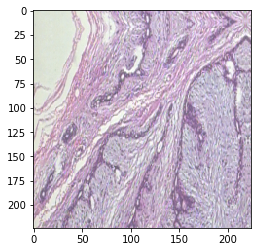

In [4]:
dataset = BREAKHIST_DATASET(SHAPE, 1, range(4), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)

for ix, data in enumerate(dataset.data_generator()):
    img, y = data
    print(img)
    print(img.shape)
    print("-"*10)
    print(y)
    print(y.shape)
    print("-"*10)
    print(img[0,:,:,:].shape)
    plt.imshow(img[0,:,:,:])
    plt.show()
    
    if ix==0:
        break

In [5]:
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [6]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [7]:
# copied from https://github.com/kobiso/CBAM-keras/blob/master/models/attention_module.py
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._keras_shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [8]:
# copied from https://gist.github.com/mjdietzx/5319e42637ed7ef095d430cb5c5e8c64
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [9]:
def create_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(2, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [10]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

for ix, (train_index, test_index) in enumerate(kf.split(range(len(dataset.split_train_test("train")[0])))):
                                               
    tg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, train_index, BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)
    vg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, test_index , BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False)
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.9,
                             cycle_length=10,
                             mult_factor=2.)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=[precision, recall, f1, 'acc'])

    model_ckpt = "BREAKHIST_FOLD_"+str(ix)+".h5"
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir='./log_'+str(ix), update_freq='batch'), 
                 schedule] 
                                               
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index)//BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(test_index)//BATCH_SIZE,
                        callbacks=callbacks)


Epoch 1/100
 - 79s - loss: 0.5477 - precision: 0.7335 - recall: 0.7335 - f1: 0.7335 - acc: 0.7335 - val_loss: 0.3880 - val_precision: 0.8077 - val_recall: 0.8077 - val_f1: 0.8077 - val_acc: 0.8077

Epoch 00001: val_loss improved from inf to 0.38805, saving model to BREAKHIST_FOLD_0.h5
Epoch 2/100
 - 47s - loss: 0.4859 - precision: 0.7799 - recall: 0.7799 - f1: 0.7799 - acc: 0.7799 - val_loss: 3.6210 - val_precision: 0.2724 - val_recall: 0.2724 - val_f1: 0.2724 - val_acc: 0.2724

Epoch 00002: val_loss did not improve from 0.38805
Epoch 3/100
 - 57s - loss: 0.4850 - precision: 0.7830 - recall: 0.7830 - f1: 0.7830 - acc: 0.7830 - val_loss: 0.6729 - val_precision: 0.6763 - val_recall: 0.6763 - val_f1: 0.6763 - val_acc: 0.6763

Epoch 00003: val_loss did not improve from 0.38805
Epoch 4/100
 - 45s - loss: 0.4827 - precision: 0.7869 - recall: 0.7869 - f1: 0.7869 - acc: 0.7869 - val_loss: 1.0960 - val_precision: 0.6186 - val_recall: 0.6186 - val_f1: 0.6186 - val_acc: 0.6186

Epoch 00004: val_l


Epoch 00065: val_loss did not improve from 0.04774
Epoch 66/100
 - 35s - loss: 0.1130 - precision: 0.9575 - recall: 0.9575 - f1: 0.9575 - acc: 0.9575 - val_loss: 0.5093 - val_precision: 0.8301 - val_recall: 0.8301 - val_f1: 0.8301 - val_acc: 0.8301

Epoch 00066: val_loss did not improve from 0.04774
Epoch 67/100
 - 35s - loss: 0.1386 - precision: 0.9473 - recall: 0.9473 - f1: 0.9473 - acc: 0.9473 - val_loss: 0.6595 - val_precision: 0.8173 - val_recall: 0.8173 - val_f1: 0.8173 - val_acc: 0.8173

Epoch 00067: val_loss did not improve from 0.04774
Epoch 68/100
 - 35s - loss: 0.1841 - precision: 0.9340 - recall: 0.9340 - f1: 0.9340 - acc: 0.9340 - val_loss: 0.2272 - val_precision: 0.9423 - val_recall: 0.9423 - val_f1: 0.9423 - val_acc: 0.9423

Epoch 00068: val_loss did not improve from 0.04774
Epoch 69/100
 - 36s - loss: 0.1987 - precision: 0.9206 - recall: 0.9206 - f1: 0.9206 - acc: 0.9206 - val_loss: 0.5124 - val_precision: 0.8397 - val_recall: 0.8397 - val_f1: 0.8397 - val_acc: 0.8397



Epoch 00098: val_loss did not improve from 0.04774
Epoch 99/100
 - 36s - loss: 0.1413 - precision: 0.9513 - recall: 0.9513 - f1: 0.9513 - acc: 0.9513 - val_loss: 1.4506 - val_precision: 0.6154 - val_recall: 0.6154 - val_f1: 0.6154 - val_acc: 0.6154

Epoch 00099: val_loss did not improve from 0.04774
Epoch 100/100
 - 35s - loss: 0.1186 - precision: 0.9536 - recall: 0.9536 - f1: 0.9536 - acc: 0.9536 - val_loss: 0.3406 - val_precision: 0.9167 - val_recall: 0.9167 - val_f1: 0.9167 - val_acc: 0.9167

Epoch 00100: val_loss did not improve from 0.04774
Epoch 1/100
 - 37s - loss: 0.1744 - precision: 0.9347 - recall: 0.9347 - f1: 0.9347 - acc: 0.9347 - val_loss: 0.9211 - val_precision: 0.7724 - val_recall: 0.7724 - val_f1: 0.7724 - val_acc: 0.7724

Epoch 00001: val_loss improved from inf to 0.92109, saving model to BREAKHIST_FOLD_1.h5
Epoch 2/100
 - 35s - loss: 0.1255 - precision: 0.9520 - recall: 0.9520 - f1: 0.9520 - acc: 0.9520 - val_loss: 0.4958 - val_precision: 0.7276 - val_recall: 0.7276


Epoch 00029: val_loss did not improve from 0.05392
Epoch 30/100
 - 36s - loss: 0.1457 - precision: 0.9481 - recall: 0.9481 - f1: 0.9481 - acc: 0.9481 - val_loss: 0.1291 - val_precision: 0.9519 - val_recall: 0.9519 - val_f1: 0.9519 - val_acc: 0.9519

Epoch 00030: val_loss did not improve from 0.05392
Epoch 31/100
 - 35s - loss: 0.1268 - precision: 0.9560 - recall: 0.9560 - f1: 0.9560 - acc: 0.9560 - val_loss: 0.8651 - val_precision: 0.7853 - val_recall: 0.7853 - val_f1: 0.7853 - val_acc: 0.7853

Epoch 00031: val_loss did not improve from 0.05392
Epoch 32/100
 - 35s - loss: 0.1332 - precision: 0.9520 - recall: 0.9520 - f1: 0.9520 - acc: 0.9520 - val_loss: 0.1553 - val_precision: 0.9327 - val_recall: 0.9327 - val_f1: 0.9327 - val_acc: 0.9327

Epoch 00032: val_loss did not improve from 0.05392
Epoch 33/100
 - 36s - loss: 0.1014 - precision: 0.9654 - recall: 0.9654 - f1: 0.9654 - acc: 0.9654 - val_loss: 0.0882 - val_precision: 0.9647 - val_recall: 0.9647 - val_f1: 0.9647 - val_acc: 0.9647



Epoch 00062: val_loss did not improve from 0.05392
Epoch 63/100
 - 36s - loss: 0.0847 - precision: 0.9717 - recall: 0.9717 - f1: 0.9717 - acc: 0.9717 - val_loss: 0.0974 - val_precision: 0.9583 - val_recall: 0.9583 - val_f1: 0.9583 - val_acc: 0.9583

Epoch 00063: val_loss did not improve from 0.05392
Epoch 64/100
 - 36s - loss: 0.0654 - precision: 0.9780 - recall: 0.9780 - f1: 0.9780 - acc: 0.9780 - val_loss: 0.0675 - val_precision: 0.9776 - val_recall: 0.9776 - val_f1: 0.9776 - val_acc: 0.9776

Epoch 00064: val_loss did not improve from 0.05392
Epoch 65/100
 - 36s - loss: 0.0573 - precision: 0.9843 - recall: 0.9843 - f1: 0.9843 - acc: 0.9843 - val_loss: 0.0435 - val_precision: 0.9872 - val_recall: 0.9872 - val_f1: 0.9872 - val_acc: 0.9872

Epoch 00065: val_loss improved from 0.05392 to 0.04355, saving model to BREAKHIST_FOLD_1.h5
Epoch 66/100
 - 36s - loss: 0.0652 - precision: 0.9756 - recall: 0.9756 - f1: 0.9756 - acc: 0.9756 - val_loss: 0.0545 - val_precision: 0.9712 - val_recall: 0


Epoch 00095: val_loss did not improve from 0.02675
Epoch 96/100
 - 36s - loss: 0.0568 - precision: 0.9827 - recall: 0.9827 - f1: 0.9827 - acc: 0.9827 - val_loss: 0.0959 - val_precision: 0.9647 - val_recall: 0.9647 - val_f1: 0.9647 - val_acc: 0.9647

Epoch 00096: val_loss did not improve from 0.02675
Epoch 97/100
 - 36s - loss: 0.0543 - precision: 0.9772 - recall: 0.9772 - f1: 0.9772 - acc: 0.9772 - val_loss: 0.5699 - val_precision: 0.8077 - val_recall: 0.8077 - val_f1: 0.8077 - val_acc: 0.8077

Epoch 00097: val_loss did not improve from 0.02675
Epoch 98/100
 - 36s - loss: 0.0496 - precision: 0.9835 - recall: 0.9835 - f1: 0.9835 - acc: 0.9835 - val_loss: 0.1835 - val_precision: 0.9231 - val_recall: 0.9231 - val_f1: 0.9231 - val_acc: 0.9231

Epoch 00098: val_loss did not improve from 0.02675
Epoch 99/100
 - 36s - loss: 0.0645 - precision: 0.9764 - recall: 0.9764 - f1: 0.9764 - acc: 0.9764 - val_loss: 1.6979 - val_precision: 0.6859 - val_recall: 0.6859 - val_f1: 0.6859 - val_acc: 0.6859



Epoch 00027: val_loss did not improve from 0.02254
Epoch 28/100
 - 36s - loss: 0.0699 - precision: 0.9756 - recall: 0.9756 - f1: 0.9756 - acc: 0.9756 - val_loss: 0.0656 - val_precision: 0.9808 - val_recall: 0.9808 - val_f1: 0.9808 - val_acc: 0.9808

Epoch 00028: val_loss did not improve from 0.02254
Epoch 29/100
 - 36s - loss: 0.0868 - precision: 0.9654 - recall: 0.9654 - f1: 0.9654 - acc: 0.9654 - val_loss: 0.2851 - val_precision: 0.8782 - val_recall: 0.8782 - val_f1: 0.8782 - val_acc: 0.8782

Epoch 00029: val_loss did not improve from 0.02254
Epoch 30/100
 - 36s - loss: 0.0746 - precision: 0.9693 - recall: 0.9693 - f1: 0.9693 - acc: 0.9693 - val_loss: 0.2140 - val_precision: 0.9263 - val_recall: 0.9263 - val_f1: 0.9263 - val_acc: 0.9263

Epoch 00030: val_loss did not improve from 0.02254
Epoch 31/100
 - 36s - loss: 0.1056 - precision: 0.9607 - recall: 0.9607 - f1: 0.9607 - acc: 0.9607 - val_loss: 1.1071 - val_precision: 0.6955 - val_recall: 0.6955 - val_f1: 0.6955 - val_acc: 0.6955



Epoch 00060: val_loss did not improve from 0.00854
Epoch 61/100
 - 36s - loss: 0.0707 - precision: 0.9717 - recall: 0.9717 - f1: 0.9717 - acc: 0.9717 - val_loss: 3.6495 - val_precision: 0.4455 - val_recall: 0.4455 - val_f1: 0.4455 - val_acc: 0.4455

Epoch 00061: val_loss did not improve from 0.00854
Epoch 62/100
 - 36s - loss: 0.0769 - precision: 0.9709 - recall: 0.9709 - f1: 0.9709 - acc: 0.9709 - val_loss: 0.3124 - val_precision: 0.9295 - val_recall: 0.9295 - val_f1: 0.9295 - val_acc: 0.9295

Epoch 00062: val_loss did not improve from 0.00854
Epoch 63/100
 - 35s - loss: 0.0734 - precision: 0.9756 - recall: 0.9756 - f1: 0.9756 - acc: 0.9756 - val_loss: 0.0560 - val_precision: 0.9872 - val_recall: 0.9872 - val_f1: 0.9872 - val_acc: 0.9872

Epoch 00063: val_loss did not improve from 0.00854
Epoch 64/100
 - 35s - loss: 0.0580 - precision: 0.9819 - recall: 0.9819 - f1: 0.9819 - acc: 0.9819 - val_loss: 0.0153 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000



Epoch 00093: val_loss did not improve from 0.00748
Epoch 94/100
 - 36s - loss: 0.0404 - precision: 0.9890 - recall: 0.9890 - f1: 0.9890 - acc: 0.9890 - val_loss: 0.0116 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000

Epoch 00094: val_loss did not improve from 0.00748
Epoch 95/100
 - 35s - loss: 0.0467 - precision: 0.9811 - recall: 0.9811 - f1: 0.9811 - acc: 0.9811 - val_loss: 0.0208 - val_precision: 0.9904 - val_recall: 0.9904 - val_f1: 0.9904 - val_acc: 0.9904

Epoch 00095: val_loss did not improve from 0.00748
Epoch 96/100
 - 36s - loss: 0.0598 - precision: 0.9811 - recall: 0.9811 - f1: 0.9811 - acc: 0.9811 - val_loss: 0.1023 - val_precision: 0.9455 - val_recall: 0.9455 - val_f1: 0.9455 - val_acc: 0.9455

Epoch 00096: val_loss did not improve from 0.00748
Epoch 97/100
 - 36s - loss: 0.0541 - precision: 0.9811 - recall: 0.9811 - f1: 0.9811 - acc: 0.9811 - val_loss: 0.0679 - val_precision: 0.9744 - val_recall: 0.9744 - val_f1: 0.9744 - val_acc: 0.9744



Epoch 00026: val_loss did not improve from 0.02498
Epoch 27/100
 - 36s - loss: 0.0644 - precision: 0.9835 - recall: 0.9835 - f1: 0.9835 - acc: 0.9835 - val_loss: 0.0322 - val_precision: 0.9904 - val_recall: 0.9904 - val_f1: 0.9904 - val_acc: 0.9904

Epoch 00027: val_loss did not improve from 0.02498
Epoch 28/100
 - 36s - loss: 0.0520 - precision: 0.9866 - recall: 0.9866 - f1: 0.9866 - acc: 0.9866 - val_loss: 0.0143 - val_precision: 0.9936 - val_recall: 0.9936 - val_f1: 0.9936 - val_acc: 0.9936

Epoch 00028: val_loss improved from 0.02498 to 0.01427, saving model to BREAKHIST_FOLD_3.h5
Epoch 29/100
 - 36s - loss: 0.0576 - precision: 0.9788 - recall: 0.9788 - f1: 0.9788 - acc: 0.9788 - val_loss: 0.1693 - val_precision: 0.9231 - val_recall: 0.9231 - val_f1: 0.9231 - val_acc: 0.9231

Epoch 00029: val_loss did not improve from 0.01427
Epoch 30/100
 - 36s - loss: 0.0609 - precision: 0.9772 - recall: 0.9772 - f1: 0.9772 - acc: 0.9772 - val_loss: 0.1355 - val_precision: 0.9583 - val_recall: 0


Epoch 00059: val_loss did not improve from 0.01028
Epoch 60/100
 - 36s - loss: 0.0600 - precision: 0.9772 - recall: 0.9772 - f1: 0.9772 - acc: 0.9772 - val_loss: 0.2427 - val_precision: 0.8974 - val_recall: 0.8974 - val_f1: 0.8974 - val_acc: 0.8974

Epoch 00060: val_loss did not improve from 0.01028
Epoch 61/100
 - 35s - loss: 0.0565 - precision: 0.9764 - recall: 0.9764 - f1: 0.9764 - acc: 0.9764 - val_loss: 0.7559 - val_precision: 0.7853 - val_recall: 0.7853 - val_f1: 0.7853 - val_acc: 0.7853

Epoch 00061: val_loss did not improve from 0.01028
Epoch 62/100
 - 35s - loss: 0.0434 - precision: 0.9851 - recall: 0.9851 - f1: 0.9851 - acc: 0.9851 - val_loss: 0.6226 - val_precision: 0.7756 - val_recall: 0.7756 - val_f1: 0.7756 - val_acc: 0.7756

Epoch 00062: val_loss did not improve from 0.01028
Epoch 63/100
 - 35s - loss: 0.0564 - precision: 0.9788 - recall: 0.9788 - f1: 0.9788 - acc: 0.9788 - val_loss: 0.0441 - val_precision: 0.9744 - val_recall: 0.9744 - val_f1: 0.9744 - val_acc: 0.9744



Epoch 00092: val_loss did not improve from 0.00587
Epoch 93/100
 - 35s - loss: 0.0412 - precision: 0.9866 - recall: 0.9866 - f1: 0.9866 - acc: 0.9866 - val_loss: 0.0255 - val_precision: 0.9872 - val_recall: 0.9872 - val_f1: 0.9872 - val_acc: 0.9872

Epoch 00093: val_loss did not improve from 0.00587
Epoch 94/100
 - 35s - loss: 0.0310 - precision: 0.9937 - recall: 0.9937 - f1: 0.9937 - acc: 0.9937 - val_loss: 0.0195 - val_precision: 0.9936 - val_recall: 0.9936 - val_f1: 0.9936 - val_acc: 0.9936

Epoch 00094: val_loss did not improve from 0.00587
Epoch 95/100
 - 36s - loss: 0.0181 - precision: 0.9953 - recall: 0.9953 - f1: 0.9953 - acc: 0.9953 - val_loss: 0.0110 - val_precision: 0.9968 - val_recall: 0.9968 - val_f1: 0.9968 - val_acc: 0.9968

Epoch 00095: val_loss did not improve from 0.00587
Epoch 96/100
 - 36s - loss: 0.0494 - precision: 0.9898 - recall: 0.9898 - f1: 0.9898 - acc: 0.9898 - val_loss: 0.1711 - val_precision: 0.9391 - val_recall: 0.9391 - val_f1: 0.9391 - val_acc: 0.9391



Epoch 00024: val_loss did not improve from 0.01724
Epoch 25/100
 - 36s - loss: 0.0429 - precision: 0.9843 - recall: 0.9843 - f1: 0.9843 - acc: 0.9843 - val_loss: 0.4993 - val_precision: 0.7917 - val_recall: 0.7917 - val_f1: 0.7917 - val_acc: 0.7917

Epoch 00025: val_loss did not improve from 0.01724
Epoch 26/100
 - 35s - loss: 0.0701 - precision: 0.9796 - recall: 0.9796 - f1: 0.9796 - acc: 0.9796 - val_loss: 0.3726 - val_precision: 0.8462 - val_recall: 0.8462 - val_f1: 0.8462 - val_acc: 0.8462

Epoch 00026: val_loss did not improve from 0.01724
Epoch 27/100
 - 36s - loss: 0.0332 - precision: 0.9898 - recall: 0.9898 - f1: 0.9898 - acc: 0.9898 - val_loss: 0.0549 - val_precision: 0.9808 - val_recall: 0.9808 - val_f1: 0.9808 - val_acc: 0.9808

Epoch 00027: val_loss did not improve from 0.01724
Epoch 28/100
 - 36s - loss: 0.0249 - precision: 0.9937 - recall: 0.9937 - f1: 0.9937 - acc: 0.9937 - val_loss: 0.0135 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000



Epoch 00057: val_loss did not improve from 0.00502
Epoch 58/100
 - 36s - loss: 0.0559 - precision: 0.9819 - recall: 0.9819 - f1: 0.9819 - acc: 0.9819 - val_loss: 0.0119 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000

Epoch 00058: val_loss did not improve from 0.00502
Epoch 59/100
 - 36s - loss: 0.0347 - precision: 0.9851 - recall: 0.9851 - f1: 0.9851 - acc: 0.9851 - val_loss: 0.1722 - val_precision: 0.9327 - val_recall: 0.9327 - val_f1: 0.9327 - val_acc: 0.9327

Epoch 00059: val_loss did not improve from 0.00502
Epoch 60/100
 - 36s - loss: 0.0526 - precision: 0.9874 - recall: 0.9874 - f1: 0.9874 - acc: 0.9874 - val_loss: 2.8511 - val_precision: 0.5032 - val_recall: 0.5032 - val_f1: 0.5032 - val_acc: 0.5032

Epoch 00060: val_loss did not improve from 0.00502
Epoch 61/100
 - 36s - loss: 0.0704 - precision: 0.9709 - recall: 0.9709 - f1: 0.9709 - acc: 0.9709 - val_loss: 0.3630 - val_precision: 0.9038 - val_recall: 0.9038 - val_f1: 0.9038 - val_acc: 0.9038



Epoch 00090: val_loss did not improve from 0.00502
Epoch 91/100
 - 36s - loss: 0.0312 - precision: 0.9874 - recall: 0.9874 - f1: 0.9874 - acc: 0.9874 - val_loss: 0.0172 - val_precision: 0.9968 - val_recall: 0.9968 - val_f1: 0.9968 - val_acc: 0.9968

Epoch 00091: val_loss did not improve from 0.00502
Epoch 92/100
 - 36s - loss: 0.0396 - precision: 0.9874 - recall: 0.9874 - f1: 0.9874 - acc: 0.9874 - val_loss: 0.0100 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000

Epoch 00092: val_loss did not improve from 0.00502
Epoch 93/100
 - 36s - loss: 0.0189 - precision: 0.9961 - recall: 0.9961 - f1: 0.9961 - acc: 0.9961 - val_loss: 0.0112 - val_precision: 0.9936 - val_recall: 0.9936 - val_f1: 0.9936 - val_acc: 0.9936

Epoch 00093: val_loss did not improve from 0.00502
Epoch 94/100
 - 35s - loss: 0.0313 - precision: 0.9882 - recall: 0.9882 - f1: 0.9882 - acc: 0.9882 - val_loss: 0.0127 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1: 1.0000 - val_acc: 1.0000


In [11]:
def get_test_data():
    gen = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, range(1), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False).split_train_test("test")
                       
    x = np.empty((len(gen[0]),)+SHAPE, dtype=np.float32)
    y = np.empty((len(gen[1]), 2), dtype=np.float32)
    
    for ix, path in tqdm(enumerate(gen[0])):
        img = np.array(Image.open(gen[0][ix]))
        img = resize(img, SHAPE)

        label = gen[1][ix]

        x[ix] = img
        y[ix] = label
        
    return x, y

In [12]:
x, y = get_test_data()

399it [00:17, 23.02it/s]


In [13]:
# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

In [14]:
models = []
for i in range(5):
    model = load_model("BREAKHIST_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    print(model.evaluate(x, y, verbose=0))
    models.append(model)

[0.09851691595519096, 0.9674185463659147, 0.9674185463659147, 0.9674185033430133, 0.9674185463659147]
[0.08233044977138813, 0.9724310776942355, 0.9724310776942355, 0.9724310442319789, 0.9724310776942355]
[0.05479078155879239, 0.974937343358396, 0.974937343358396, 0.9749373194567841, 0.974937343358396]
[0.06933665006680596, 0.9799498746867168, 0.9799498746867168, 0.9799498507851049, 0.9799498746867168]
[0.10550234063451451, 0.9699248121794602, 0.9699248121794602, 0.969924771696105, 0.9699248121794602]


In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("40X - confusion matrix - 4. FOLD.jpg", dpi=150)
    plt.show()

Accuracy: 0.9799498746867168, F1_Score: 0.9768009768009769, Precision: 0.9768009768009769, Recall: 0.9768009768009769


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       126
           1       0.99      0.99      0.99       273

   micro avg       0.98      0.98      0.98       399
   macro avg       0.98      0.98      0.98       399
weighted avg       0.98      0.98      0.98       399
 samples avg       0.98      0.98      0.98       399





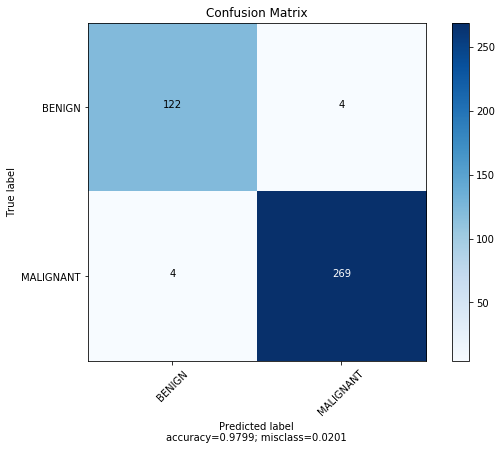

In [16]:
y_preds = threshold_arr(models[3].predict(x, verbose=0))

results = precision_recall_fscore_support(y, y_preds ,average='macro')
acc = accuracy_score(y, y_preds)

print("Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ['BENIGN', 'MALIGNANT'],
                      title        = "Confusion Matrix")

In [17]:
import time
for i in range(5): 
    img = np.array(Image.open(BASE_DIR+"benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-009.png"))
    x = resize(img, SHAPE)
    x = x.reshape((1,) + x.shape) 
    start = time.time()
    prediction = models[3].predict(x, batch_size=1)
    finish = time.time()
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[1. 0.]]
102.12922096252441 ms
***
[[1. 0.]]
15.627622604370117 ms
***
[[1. 0.]]
1.2509822845458984 ms
***
[[1. 0.]]
8.02302360534668 ms
***
[[1. 0.]]
0.0 ms
***
